In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#Libraries for scaling and splitting the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
#Libraries for handling imbalanced data sets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
#Libraries for model evaluation
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
df = pd.read_csv("../input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Understanding the data set
- Due to confidentiality issues many of the parameters cannot be names (V1-v28)
- Time denotes the time since the first transaction in the dataset
- Amount is the amount of the transaction
- Class is whether the transaction is fraud or not (0 = Not Fraud, 1 = Fraud)
## What percentage of the data is fraud?
- We would expect only a small amount of the transactions to be fraud. We should check this is true for the dataset.

In [3]:
x = df["Class"].value_counts()
print("None fraud = {nf}, fraud = {f}, Percentage fraud = {pf}%".format(nf=x[0], f=x[1], pf=(x[1]/x[0])*100))

None fraud = 284315, fraud = 492, Percentage fraud = 0.17304750013189596%


We see that fraudulent transactions make up less than 1% of events.

Likewise we know that the v values are all the principle values obtained from PCA.

The remaining two are the time of the transaction and the amount of the transaction.

We can visualise these as histograms.

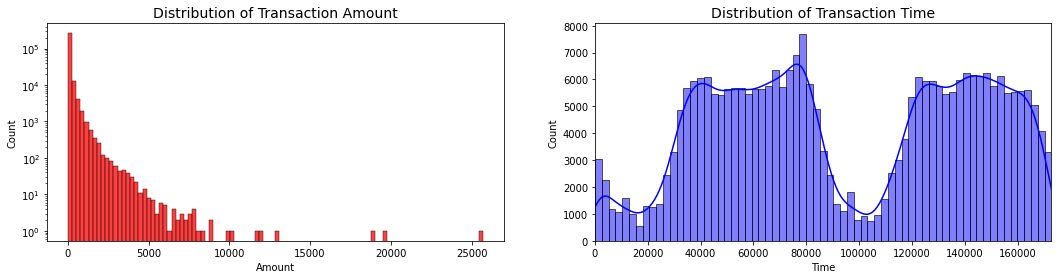

In [4]:


fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.histplot(data=df, x='Amount', ax=ax[0], color='r', log_scale=(False, True), bins=100)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
#ax[0].set_xlim([0, max(amount_val)])

sns.histplot(data=df, x='Time', ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()



We begin by splitting the dataset into the dependent variables `X` and the class which we want to predict `y`

In [5]:
X = df.iloc[:, df.columns != "Class"]
y = df.iloc[:, df.columns == "Class"]
print(X.shape, y.shape)

(284807, 30) (284807, 1)


We split the data into two sets, a training set which is 70% of our data and a test set which is 30%

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

All of the V variables have already been normalised so we only need to normalise and scale `Time` and `Amount`

In [7]:
scale_fit = StandardScaler().fit(X_train['Amount'].values.reshape(-1,1))
X_train['Amount_Scaled'] = scale_fit.transform(X_train['Amount'].values.reshape(-1,1))
X_test['Amount_Scaled'] = scale_fit.transform(X_test['Amount'].values.reshape(-1,1))

scale_fit2 = StandardScaler().fit(X_train['Time'].values.reshape(-1,1))
X_train['Time_Scaled'] = scale_fit2.transform(X_train['Time'].values.reshape(-1,1))
X_test['Time_Scaled'] = scale_fit2.transform(X_test['Time'].values.reshape(-1,1))
X_train.drop(['Time','Amount'],axis=1, inplace=True)
X_test.drop(['Time','Amount'],axis=1, inplace=True)
print(X_train.shape, X_test.shape)


(199364, 30) (85443, 30)


## Testing a simplent logitic regression model

We can first look at how a simple logitic regression model does at determining whether a transaction is fraudulent or not.

In [8]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [9]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_train, y_train.values.ravel())


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [10]:

y_pred = logreg_cv.predict(X_test)
recall_score_result = recall_score (y_test,y_pred)
accuracy_score_result = accuracy_score(y_test, y_pred)

print("The accuracy of the model is {accuracy}.".format(accuracy=accuracy_score_result))
print("The recall score of the model is {recall}.".format(recall=recall_score_result))

The accuracy of the model is 0.9992743700478681.
The recall score of the model is 0.6323529411764706.


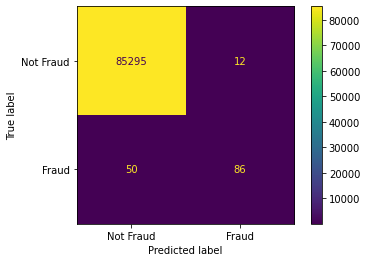

In [11]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Not Fraud", "Fraud"])
disp.plot()
plt.show()

Here we can see why using recall score is import to test the performance of the model vs just looking at the accuracy of the predictions. As non-fraudulent purchases dominate the data it is possible to have a very high accuracy with a poor recall score.

From the confusion matrix we can see that the model does a good job at accurately predicting the not fraudulant purchases correctly. However, it is less able to predict the fraud cases as such. This is likely as the model becomes biases to the dominating class which in this case is not fraudulant transactions.

# Undersampling the data
- As we have a large imbalance between the number of ligitimate transactions and the number of fraudulent transactions it will be beneficial to undersample the data.
- This stops the model becoming to well trained on legitimate transactions and mitigates the amount of fraudulent events being missing
- By undersampling the data we randomly discard a fraction of our dominant class such that we end up with an equal amount of both classes in the training data.
- To do the undersampling we employ the `RandomUnderSampler()` from the ImbalancedLearn library
- We only undersample the training data as in a real world example we expect the unseen data to be predominantly legitimate transactions

In [12]:
rus = RandomUnderSampler(random_state=0)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(y_resampled.shape)
print('Resampled dataset shape %s' % Counter(y_resampled.values.ravel()))


(712, 1)
Resampled dataset shape Counter({0: 356, 1: 356})


We can see we now have an equal number of legitimate transactions and fraudulent transactions in our training set

## Testing different models
- We can repeat our previous test of a simple Logistic Regression model and also test out some other classifiers

In [13]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv=10)
logreg_cv.fit(X_resampled, y_resampled.values.ravel())
y_pred = logreg_cv.predict(X_test)
recall_score_result = recall_score (y_test,y_pred)
accuracy_score_result = accuracy_score(y_test, y_pred)

print("The accuracy of the model is {accuracy}.".format(accuracy=accuracy_score_result))
print("The recall score of the model is {recall}.".format(recall=recall_score_result))

The accuracy of the model is 0.9628290205166017.
The recall score of the model is 0.9338235294117647.


In [14]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

tree_cv = GridSearchCV(tree, parameters, cv = 10)
tree_cv.fit(X_resampled, y_resampled.values.ravel())
y_pred = tree_cv.predict(X_test)
recall_score_result = recall_score (y_test,y_pred)
accuracy_score_result = accuracy_score(y_test, y_pred)

print("The accuracy of the model is {accuracy}.".format(accuracy=accuracy_score_result))
print("The recall score of the model is {recall}.".format(recall=recall_score_result))

The accuracy of the model is 0.9077513664080147.
The recall score of the model is 0.9191176470588235.


In [15]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

knn_cv = GridSearchCV(KNN, parameters, cv = 10)
knn_cv.fit(X_resampled, y_resampled.values.ravel())
y_pred = knn_cv.predict(X_test)
recall_score_result = recall_score (y_test,y_pred)
accuracy_score_result = accuracy_score(y_test, y_pred)

print("The accuracy of the model is {accuracy}.".format(accuracy=accuracy_score_result))
print("The recall score of the model is {recall}.".format(recall=recall_score_result))

The accuracy of the model is 0.9805835469260209.
The recall score of the model is 0.8970588235294118.


In [16]:
clf = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000, random_state=10).fit(X_resampled, y_resampled.values.ravel())
y_pred = clf.predict(X_test)
recall_score_result = recall_score (y_test,y_pred)
accuracy_score_result = accuracy_score(y_test, y_pred)

print("The accuracy of the model is {accuracy}.".format(accuracy=accuracy_score_result))
print("The recall score of the model is {recall}.".format(recall=recall_score_result))

The accuracy of the model is 0.9528808679470524.
The recall score of the model is 0.9485294117647058.


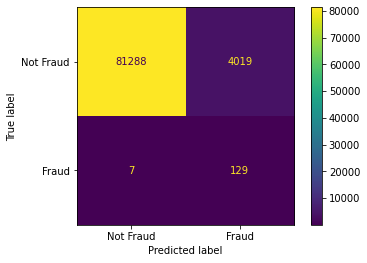

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Not Fraud", "Fraud"])
disp.plot()
plt.show()

### Summary

#### Results table
|Classifier|Recall|Accuracy|
|:--------:|:----:|:------:|
|Logistic Regression |0.96282902|0.93382353|
|Decision Tree       |0.94466486|0.91911764|
|KNN                   |0.98058355|0.89705882|
|Multi-Layer Perceptron|0.95288086|0.94852941|

#### Discussion
- We see that all four classifiers have a better recall score than the model trained on the non-undersampled data
- All four models have a worse model accuracy though as they are less able to well predict the non-fraudulent cases as they are exposed to less.
    - This is evidenced in the confusion matrix of the MLP classifier which does well to reproduce the Fraudulent cases but is less well able to handle the non-fraudulent cases
- While undersampling has led to a model that is better able to predict when an event is truely fraudulent, the false positive rate of not fraudulent purchases being flagged as fraudulent could be a hassle as it may lead to blocked legitimate purchases

## Oversampling the data

- One of the downsides of undersampling is that in the case of severely imbalanced data a large amount of the training data is discarded
- Oversampling is an alternative method for imbalanced data that instead creates additional items of the less dominant class and inserts them into the training set
- In the case of SMOTE (Synthetic Minority Over-sampling Technique), that is employed here, these synthetic events are created randomly by joining the nearest neighbours of the minority class in the "feature space"
- For a detailed discussion of SMOTE see [this link](https://arxiv.org/abs/1106.1813)

In [18]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled.values.ravel()))

Resampled dataset shape Counter({0: 199008, 1: 199008})


We take our best performing classifier from the undersampling case and now apply it to the oversampled data

In [19]:
clf = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000, random_state=10).fit(X_resampled, y_resampled.values.ravel())
y_pred = clf.predict(X_test)
recall_score_result = recall_score (y_test,y_pred)
accuracy_score_result = accuracy_score(y_test, y_pred)

print("The accuracy of the model is {accuracy}.".format(accuracy=accuracy_score_result))
print("The recall score of the model is {recall}.".format(recall=recall_score_result))

The accuracy of the model is 0.9993679997191109.
The recall score of the model is 0.8382352941176471.


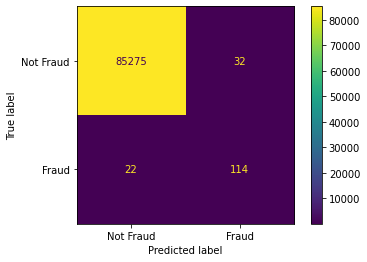

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Not Fraud", "Fraud"])
disp.plot()
plt.show()

### Summary
- We obtain a much better accuracy than for the undersampled case with the model again able to well predict the non-fraudulent purchases well
- The model however performs worse on accurately predicting fraudulent transactions, with a greater number of fraudulent transactions being identified as not fraud.
    - The performance is however better than when the non-undersampled data was used for model training.

# Conclusions
- Imbalanced data sets can cause issues when training models where it is required to accurately predict the minority class
- Both undersampling and oversampling can be used to aid in the training of models on severly imbalanced data sets
- In the case of fraudulent transactions it was found that undersampling gave the best recall score for "non-fraudulent transactions"
    - This came at the cost of an increased false positive rate though which in a real world scenario could lead to annoyed customers having their purchases declined
- Oversampling was found to give an improvement on just using the initial training data weightings but could not match the recall score of the undersampled data
    - Using oversampling in a real world scenario may be preferable as while it misses more fraudulent transactions, it has a better overall model accuracy

# Further works
- As SMOTE relies upon creating synthetic values in the minority class it may be found that it is sensitive to outliers in the training data.
    - It could be investigated whether removing any outliers from the training data improves its performance
- In the [paper](https://arxiv.org/abs/1106.1813) referenced above the authors note that a combination of undersampling and oversampling can be used to obtain better classifier performance.